In [1]:
# imports 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

## Часть 1: О теореме Байеса

### Вопрос 1

Прокурор сделал ошибку при рассуждении. По его словам он посчитал вероятность принадлежности группы крови подсудимому в случае его невиновности:

$$P(\text{blood | innocent})$$ 

Он взял всех невиновных людей и подумал что только у 1% этих людей будет редкая группа крови, а у 99% невиновных её не будет. И основываясь на таком рассуждении, он сделал заключение что любой человек, у которого есть эта редкая группа крови, будет являться виновным с вероятностью 99%.
Его рассуждение неверно. Мы не должны заведомо предполагать виновность человека, наоборот это то что мы должны выяснить. Например, прокурор лучше бы оценил вероятность виновности подсудимого в случае его принадлежности к группе крови:

$$P(\text{innocent | blood})$$

### Вопрос 2

Адвокат посчитал вероятность того, что кровь которую они взяли принадлежит именно его подчиненному следующим путём:

$$P(\text{defendant}) = \frac{\text{defendant}}{\text{population with rare blood}}=\frac{1}{10000} = 0.00001$$ 

Адвокат чисто посчитал вероятность что его подзащитник мог бы быть убийцей, не учитывая никаких других факторов. Это очень слабое защитное доказательство и лучше бы он мог привести другие вероятности, например:

$$P(\text{innocent | blood}), P(\text{innocent | alibi}), P(\text{innocent | proof})  \text{...}$$

### Вопрос 3

Используя теорему Байеса напишем следующие зависимости (d - пациент болен, d' - пациент здоров, t - положительный результат теста, f - отрицательный результат теста):

$$P(d|t) = \frac{P(t|d)P(d)}{P(t|d)P(d) + P(t|d')P(d')}$$
$$P(d|f) = \frac{P(f|d)P(d)}{P(f|d)P(d) + P(f|d')P(d')}$$

Ниже я создам графики зависимости вероятности болезни при разных значениях ложно положительных и ложно отрицательных результатов теста

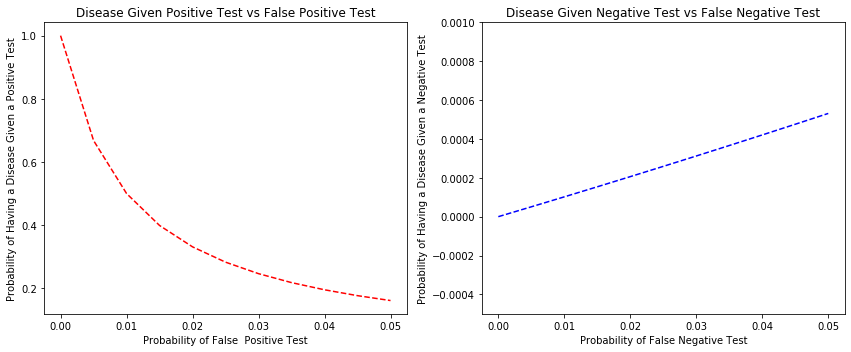

In [2]:
# function to calculate Bayes probability
def predict(p_d, p_tf_d, p_tf_notd, p_notd):
    return p_tf_d * p_d / (p_tf_d * p_d + p_tf_notd * p_notd)

# parameters for calculations
p_d = 0.01
p_notd = 0.99

# generate list of different values for false positives and negatives
false_positives = [x / 1000.0 for x in range(0, 55, 5)]
false_negatives = [x / 1000.0 for x in range(0, 55, 5)]
false_posterior = []
true_posterior = []

# calculate posteriors for false_positives and false_negatives
for i in range(len(false_positives)):
    true_posterior.append(predict(p_d, 1 - false_positives[i], \
                                  false_positives[i], p_notd))
    false_posterior.append(predict(p_d, false_negatives[i], \
                                   1 - false_negatives[i], p_notd))

# plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)    
plt.plot(false_positives, true_posterior, '--r')
plt.title('Disease Given Positive Test vs False Positive Test')
plt.xlabel('Probability of False  Positive Test')
plt.ylabel('Probability of Having a Disease Given a Positive Test')

plt.subplot(1, 2, 2)
plt.plot(false_negatives, false_posterior, '--b')
axes = plt.gca()
axes.set_ylim([-0.0005, 0.001])
plt.title('Disease Given Negative Test vs False Negative Test')
plt.xlabel('Probability of False Negative Test')
plt.ylabel('Probability of Having a Disease Given a Negative Test')

plt.tight_layout()
plt.show()

В зависимости от возможностей исследователей можно дать различные рекомендации:
* если можно значительно снизить вероятность ложного теста, то лучше работать над улучшением положительных тестов, потому что по графику видно, что в случае улучшения положительных тестов, то вероятность правильного предсказания болезни в случае положительного теста значительно улучшается
* если можно чуть-чуть снизить вероятность ложного теста, то лучше работать над улучшением отрицательных тестов, потому при маленьких начальных улучшениях (например, от 0.05 к 0.04) мы получим больший пропорциональный скачок в точности предсказания в случае отрицательных тество по сравнению с положительными тестами, которые незначительно улучшатся 

## Часть 2: О линейной регрессии

#### (2.1) Импорт данных о коронавирусе

In [3]:
# import covid data for Russia
covid_data = pd.read_csv('owid-covid-data.csv')
rus_data = covid_data.loc[covid_data['location'] == 'Russia']
rus_data_50 = rus_data[(rus_data['date'] > '2020-03-03')  \
                       & (rus_data['date'] < '2020-04-23')]

#### (2.2a) Модель с экспоненциальным ростом за первые 50 дней
Модель построена с помошью линейной регрессии из библиотеки sklearn 

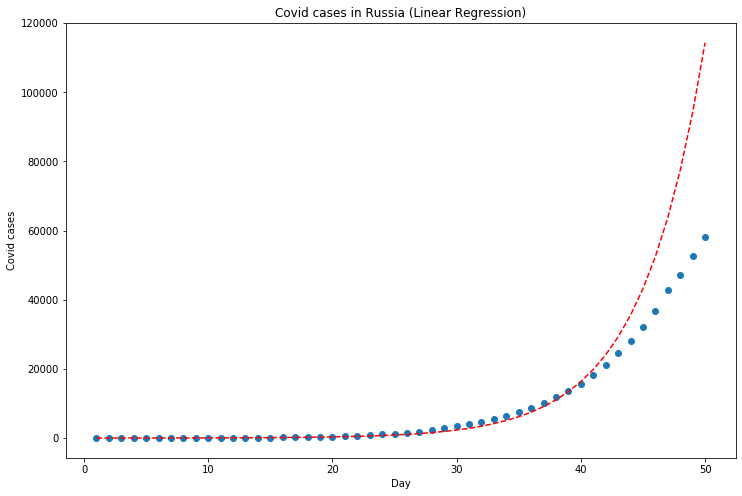

In [4]:
# get covid cases of the first 50 days
y = rus_data_50['total_cases'].to_numpy()
X = np.arange(start=1, stop=51).reshape(-1, 1)

# fitting linear regression 
linreg = LinearRegression().fit(X, np.log(y))

# generate exponential curve from linear regression
alpha = linreg.intercept_
beta = linreg.coef_
y_pred = (math.exp(alpha) * np.exp(beta * X)).flatten()

# graph the results
plt.figure(figsize=(12, 8))
plt.scatter(X, y)
plt.plot(X, y_pred, '--r')
plt.title('Covid cases in Russia (Linear Regression)')
plt.xlabel('Day')
plt.ylabel('Covid cases')
plt.show()

#### (2.2b) Апостериорное распределение параметров
Байесовская линейная регрессия ниже построена с помощью модели описанной в книге Бишопа Pattern Recognition and Machine Learning. Соответствующие ссылки к использованным формулам даны в самом коде. У меня возникли проблемы с оценкой дисперсии шума. Почему-то значение беты выходит очень низкое и в результате не могу оценить дисперсию шума

In [5]:
class BayesLinReg:
    """
    Bayesian Linear regression:
    using iterative approach where posterior works as prior
    at the next iteration (see Bishop 3.3) 
    """
    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        # Noise precision
        self.beta = beta
        # Prior's mean and covariance
        self.mean = np.zeros(n_features)
        # Smaller alpha gives broader initial prior (infinetely broad)
        self.alpha = alpha
        self.cov_inv = np.identity(n_features) / alpha

    def learn(self, x, y):
        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * np.outer(x, x)

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y * x)

        self.cov_inv = cov_inv
        self.mean = mean
        
        return self

    def predict(self, x):
        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + x @ w_cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)
    
    def covar(self):
        # Return covariance of a model
        return np.linalg.inv(self.cov_inv)
    
    # Estimate beta (noise precision) based on the posterior (Bishop eqs. 3.90, 3.95)
    def estimate_beta(self, x, y):
        gamma = self.alpha * self.mean.T @ self.mean
        coeff = 1 / (50 - gamma)
        summation = np.sum(np.power(y - x @ self.mean, 2))
        return 1 / (coeff * summation)
    
    
### REFERENCES ###

# https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf
# https://maxhalford.github.io/blog/bayesian-linear-regression/

In [6]:
# concatenate one to X for the purpose of regression fitting
ones_vector = np.ones((X.shape[0], 1))
X_ones = np.concatenate((X, ones_vector), axis = 1)

# model parameters
noise_var = np.sum((np.log(y_pred / y)) ** 2) / len(y) # empirical noise
beta = (1 / noise_var) ** 2 # equation from Bishop
alpha = 1 # wide prior distribution

# run the Bayesian regression
model = BayesLinReg(n_features=X_ones.shape[1], alpha=alpha, beta=beta)
y_kern = np.empty(len(y))
for i, (xi, yi) in enumerate(zip(X_ones, np.log(y))):
    y_kern[i] = model.predict(xi).mean()
    model.learn(xi, yi)

# predict y using Bayesian regression
my_w = np.random.multivariate_normal(model.mean, model.covar()) 
y_bayes = math.exp(my_w[1]) * np.exp(X.flatten() * my_w[0])

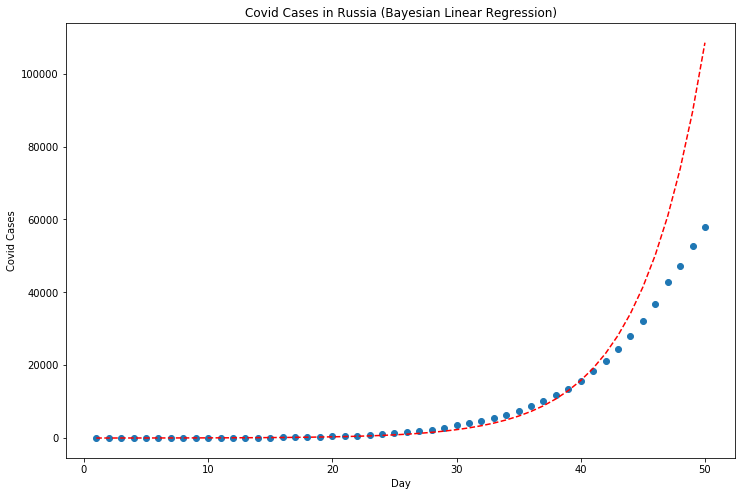

In [7]:
# graph the Bayesian regression results
plt.figure(figsize=(12, 8))
plt.scatter(X, y)
plt.plot(X, y_bayes, '--r')
plt.title('Covid Cases in Russia (Bayesian Linear Regression)')
plt.xlabel('Day')
plt.ylabel('Covid Cases')
plt.show()

#### (2.2c) Возможные предсказания Байесовской линейной регрессии
Ниже показаны возможные предсказания количества больных коронавирусом к 1 мая, 1 июня и 1 сентября.


In [8]:
# days from March to May, June and September respectively
dates = np.array([60, 90, 180])

def predict(w, dates):
    return math.exp(w[1]) * np.exp(dates * w[0])

def possible_predictions(mu, sigma, n=20):
    # possible samples of the model
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    # may, june, september predictions list
    predictions_list = [[], [], []]
    
    # iterate over samples and make predictions
    for w in my_w:
        prediction = predict(w, dates)
        predictions_list[0].append(prediction[0])
        predictions_list[1].append(prediction[1])
        predictions_list[2].append(prediction[2])
    
    return predictions_list

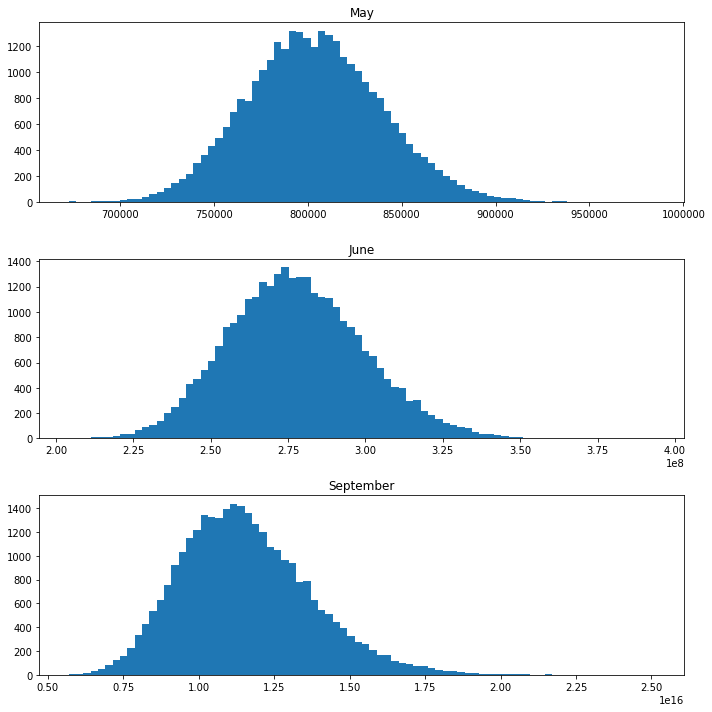

In [9]:
# make predictions from a given samples number
samples_number = 30000
predictions = possible_predictions(model.mean, model.covar(), samples_number)
bins = 80

# graph the possible predictions
fig, axs = plt.subplots(3)
fig.set_size_inches(10,10)
axs[0].hist(predictions[0], bins=bins)
axs[0].set_title('May')
axs[1].hist(predictions[1], bins=bins)
axs[1].set_title('June')
axs[2].hist(predictions[2], bins=bins)
axs[2].set_title('September')
plt.tight_layout()

#### 2.3(a) Обучение сигмоидальной функции с помощью линейной регрессии

$$ y = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{at^2}dt  $$

Можно использовать линейную регрессию следующим путём. Заметьте что данные у нас дискретные и мы можем превратить интеграл в сумму. Тогда мы получим 

$$ y = \sum_0^x e^{ax^2}$$

И использовав преобразования с логарифмом мы получим

$$ log(y) = \sum_{0}^{x} (ax^2 + bx + c) $$

Я добавил bx и с, чтобы модель лучше давала предсказания. И теперь по формуле выше можно провести линейную регрессию и получить предсказания случаев заболевания коронавирусом. 
Заметьте, при построении модели я буду предсказывать количество болезней в день, то есть ту часть, которая находится внутри знака суммы. А для предсказания заболеваний в какой-то определенный день я посчитаю сумму всех прошедших дней и прибавлю к интересующему нас дню.

#### 2.3(a) Апостериорное распределение параметров для probit функции

In [10]:
# concatenate one to X for the purpose of regression fitting
ones_vector = np.ones((X.shape[0], 1))
X_probit = np.concatenate((X, ones_vector), axis = 1)
X_probit = np.concatenate((X ** 2, X_probit), axis = 1)

# model parameters 
noise_var = np.sum((np.log(y_pred / y)) ** 2) / len(y) # empirical noise
beta = (1 / noise_var) ** 2 # equation from Bishop 
alpha = 1 # wide prior distribution

# run the Bayesian regression
probit_model = BayesLinReg(n_features=X_probit.shape[1], alpha=alpha, beta=beta)

# process y for correct linear regression purposes
y_kern_probit = np.empty(len(y))
y_accum = np.diff(y)
y_accum[y_accum == 0] = 1
for i, (xi, yi) in enumerate(zip(X_probit, np.log(y_accum))):
    y_kern_probit[i] = probit_model.predict(xi).mean()
    probit_model.learn(xi, yi)

# predict y using Bayesian regression
my_w = np.random.multivariate_normal(probit_model.mean, probit_model.covar()) 
y_probit = np.cumsum(np.exp(my_w[0] * X ** 2 + my_w[1] * X + my_w[2]))

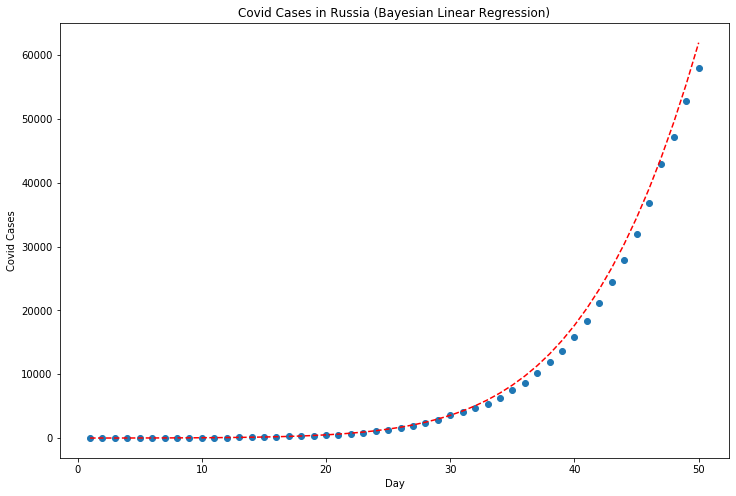

In [11]:
# graph the Bayesian regression results
plt.figure(figsize=(12, 8))
plt.scatter(X, y)
plt.plot(X, y_probit, '--r')
plt.title('Covid Cases in Russia (Bayesian Linear Regression)')
plt.xlabel('Day')
plt.ylabel('Covid Cases')
plt.show()

#### (2.2c) Возможные предсказания Байесовской линейной регрессии probit

In [12]:
# days from March to May, June and September respectively
dates = np.array([60, 90, 180])

def predict_probit(w, dates):
    return np.cumsum(np.exp(w[0] * dates ** 2 + w[1] * dates + w[2]))

def possible_probit_predictions(mu, sigma, n=20):
    # possible samples of the model
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    # may, june, september predictions list
    predictions_list = [[], [], []]
    
    # iterate over samples and make predictions
    for w in my_w:
        prediction = predict_probit(w, dates)
        predictions_list[0].append(prediction[0])
        predictions_list[1].append(prediction[1])
        predictions_list[2].append(prediction[2])
    
    return predictions_list

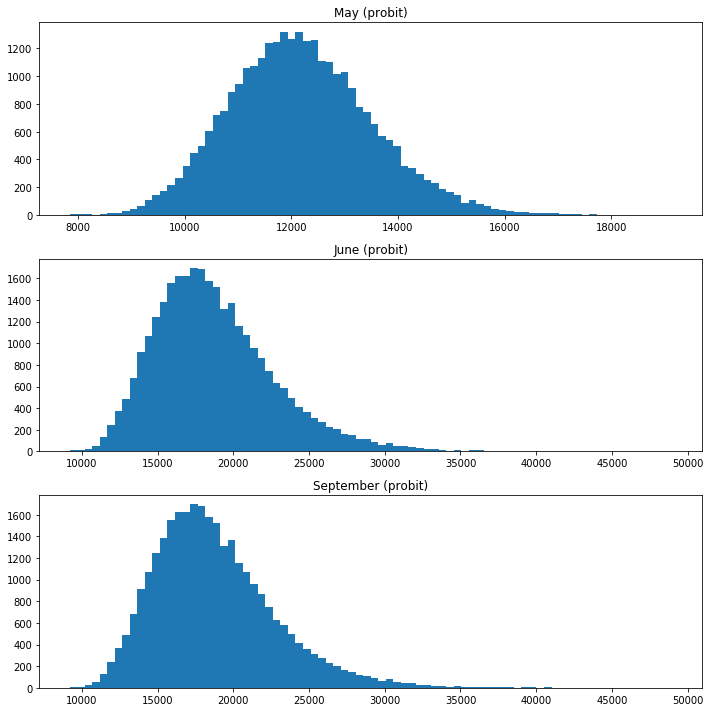

In [13]:
# make predictions from a given samples number
samples_number = 30000
bins = 80
probit_predictions = possible_probit_predictions(probit_model.mean, probit_model.covar(), \
                                                 samples_number)

# graph the possible predictions
fig, axs = plt.subplots(3)
fig.set_size_inches(10,10)
axs[0].hist(probit_predictions[0], bins=bins)
axs[0].set_title('May (probit)')
axs[1].hist(probit_predictions[1], bins=bins)
axs[1].set_title('June (probit)')
axs[2].hist(probit_predictions[2], bins=bins)
axs[2].set_title('September (probit)')
plt.tight_layout()

In [14]:
# 90th percentiles (pessimistic predictions)
may_pes = np.percentile(probit_predictions[0], 90)
june_pes = np.percentile(probit_predictions[1], 90)
sep_pes = np.percentile(probit_predictions[2], 90)

# 10th percentiles (optimistic predictions)
may_opt = np.percentile(probit_predictions[0], 10)
june_opt = np.percentile(probit_predictions[1], 10)
sep_opt = np.percentile(probit_predictions[2], 10)

print(f'Pessimistic predictions: May - {may_pes:.0f}, June - {june_pes:.0f}, September - {sep_pes:.0f}')
print(f'Optimistic predictions: May - {may_opt:.0f}, June - {june_opt:.0f}, September - {sep_opt:.0f}')

Pessimistic predictions: May - 13925, June - 24001, September - 24001
Optimistic predictions: May - 10521, June - 14194, September - 14194
